<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [169]:
import matplotlib.pyplot as plt

% matplotlib inline

In [170]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.DataFrame(boston.target, columns=['MEDV'])

df = X.join(y)

print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [171]:
# Exploratory data analysis.
# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


Across data columns, we observe the non-nulls matching the number of rows

In [172]:
# Exploratory data analysis.
# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column

X.shape

(506, 13)

Our dataset has 506 columns and 13 rows

In [173]:
# Exploratory data analysis.
# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column

X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [174]:
X.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88


Zone jumps out - needs further investigation/visualization.

In [175]:
# Exploratory data analysis.
# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column

X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1cda1390>,
      dtype=object)

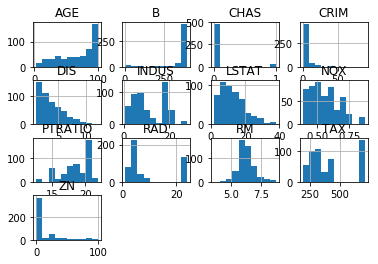

In [176]:
# Exploratory data analysis.
# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column
X.hist()

From describe() and hist(), we can see that:
- ZN, CHAS, B, and CRIM is heavily skewed
- There seems to be an integrity issue on AGE unless a lot of people in Boston are old (also see value_counts() below)

In [177]:
X.AGE.value_counts(bins = 10)

(90.29, 100.0]    168
(80.58, 90.29]     71
(70.87, 80.58]     42
(32.03, 41.74]     42
(61.16, 70.87]     39
(51.45, 61.16]     38
(41.74, 51.45]     32
(12.61, 22.32]     31
(22.32, 32.03]     29
(2.802, 12.61]     14
Name: AGE, dtype: int64

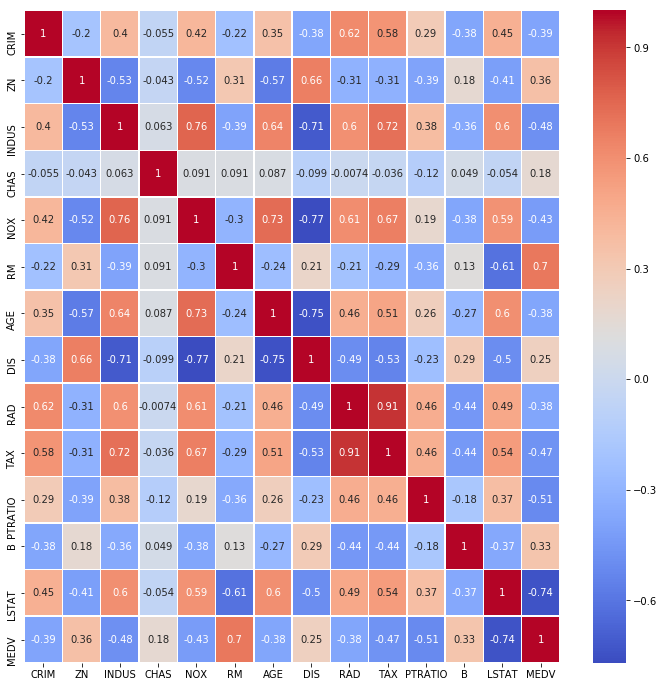

In [178]:
# Exploratory data analysis.
# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column
f,ax=plt.subplots(figsize=(12,12))
sns.heatmap(df.corr(), cmap = 'coolwarm', annot=True, ax=ax, linewidth=.5)

- Strong correlation to MEDV - RM, PTRatio, LStat, Indus, and Tax
- Between 5 features above, 1/ PTRatio and LStat have strong interaction; 2/ LStat, Indus, and Tax as well
- Choose to go with Room, PTRatio, and Indus for the linear regression modelling

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

- Following predictors to be used for the model RM, PTRATIO, LSTAT to predict MEDV

In [179]:
feature_cols = ['RM','PTRATIO','LSTAT']
Xp = X[feature_cols]

In [180]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(Xp, y)

# Print the coefficients.
print(lr.intercept_)
print(lr.coef_)

[18.56711151]
[[ 4.51542094 -0.93072256 -0.57180569]]


### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [181]:
#Using 70-30 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size = 0.30, random_state = 59)

lr = LinearRegression()
lr.fit(X_train, y_train)

# Print the coefficients.
print(lr.intercept_)
print(lr.coef_)

[18.50774506]
[[ 4.74913257 -1.04285435 -0.52517073]]


In [182]:
from sklearn import metrics

y_pred = lr.predict(X_test)

#print(np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train))))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

5.822479506265967


In [183]:
#Using 90-10 

X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size = 0.10, random_state = 59)

lr = LinearRegression()
lr.fit(X_train, y_train)

# Print the coefficients.
print(lr.intercept_)
print(lr.coef_)

[20.6908816]
[[ 4.17875088 -0.93968049 -0.56181731]]


In [184]:
y_pred = lr.predict(X_test)

#print(np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train))))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

5.184525133293067


### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [207]:
from sklearn import model_selection

kf = model_selection.KFold(n_splits=5, shuffle=True)

rmse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(Xp, y):
    lr = LinearRegression().fit(Xp.iloc[train_index], y.iloc[train_index])
    
    rmse_values.append(np.sqrt(metrics.mean_squared_error(y.iloc[test_index], lr.predict(Xp.iloc[test_index]))))
    scores.append(lr.score(Xp, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('RMSE: {}'.format(rmse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of RMSE for all folds: {}'.format(np.mean(rmse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
RMSE: 5.634945035599988
R2: 0.6782583324144691

Model 2
RMSE: 6.126612305720426
R2: 0.6758849554813671

Model 3
RMSE: 5.321245087015665
R2: 0.6762752145991309

Model 4
RMSE: 4.555891529875467
R2: 0.6776575921558484

Model 5
RMSE: 4.725211389985469
R2: 0.6783045137036569

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of RMSE for all folds: 5.272781069639403
Mean of R2 for all folds: 0.6772761216708945


In [186]:
from sklearn import model_selection

kf = model_selection.KFold(n_splits=10, shuffle=True)

rmse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(Xp, y):
    lr = LinearRegression().fit(Xp.iloc[train_index], y.iloc[train_index])
    
    rmse_values.append(np.sqrt(metrics.mean_squared_error(y.iloc[test_index], lr.predict(Xp.iloc[test_index]))))
    scores.append(lr.score(Xp, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('RMSE: {}'.format(rmse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of RMSE for all folds: {}'.format(np.mean(rmse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
RMSE: 5.339088544076712
R2: 0.6780114474352805

Model 2
RMSE: 4.544559142819445
R2: 0.6785170036492771

Model 3
RMSE: 4.520253843073351
R2: 0.678349144148163

Model 4
RMSE: 5.928025163178542
R2: 0.6777680939968838

Model 5
RMSE: 4.815967277433469
R2: 0.6783851089530017

Model 6
RMSE: 5.0128494992641786
R2: 0.6784526407113407

Model 7
RMSE: 5.8057949691547135
R2: 0.6785495981546059

Model 8
RMSE: 6.590348952161918
R2: 0.6785333667677105

Model 9
RMSE: 4.010495966460168
R2: 0.6782776039940651

Model 10
RMSE: 5.48195098939242
R2: 0.678427478548763

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of RMSE for all folds: 5.204933434701492
Mean of R2 for all folds: 0.678327148635909


# KNN Practice

In [187]:
# Read the iris data into a DataFrame
url = 'https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url)

In [188]:
# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [189]:
iris.tail()

,sepal_length,sepal_width,petal_length,petal_width,species
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica


In [190]:
#Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

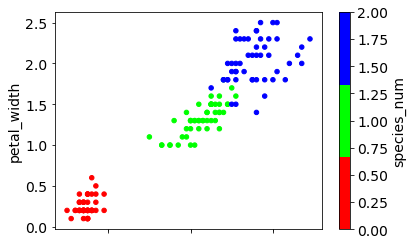

In [191]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'

def species(row):
  if row['species'] == 'setosa':
    return 0
  elif row['species'] == 'versicolor':
    return 1
  elif row['species'] == 'virginica':
    return 2
  else:
    return 3

iris['species_num'] = iris.apply(species, axis=1)

# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
iris.plot(kind='scatter', x='petal_length', y='petal_width', c='species_num', colormap = cmap_bold)

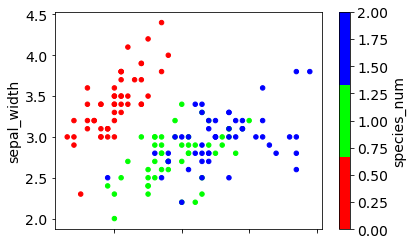

In [192]:
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES
iris.plot(kind='scatter', x='sepal_length', y='sepal_width', c='species_num', colormap = cmap_bold)

## KNN Classification of the Iris Dataset

### Create your feature matrix "X_knn"
This will be all species measurements (sepal length, petal width, etc...)

In [193]:
X_knn = iris.drop(['species','species_num'], axis = 1)

### Create your target vector "y_knn"
This will be the species type.

In [194]:
y_knn = iris.species_num

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size = 0.20, random_state = 59)

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [196]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [197]:
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.9333333333333333


### Create a Model With Five Neighbors. Did it Improve?

In [198]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.9666666666666667


### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

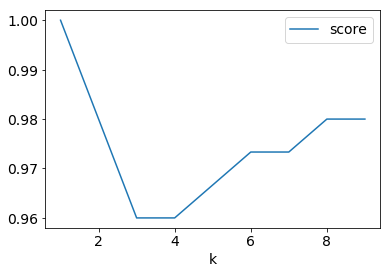

In [199]:
scores = []
for k in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_knn,y_knn)
    pred = knn.predict(X_knn)
    score = float(sum(pred == y_knn)) / len(y_knn)
    scores.append([k, score])
    
data = pd.DataFrame(scores,columns=['k','score'])
data.plot.line(x='k',y='score');

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

From the documentation: Return probability estimates for the test data X.
Probability of a given sample being in a particular class.

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [200]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [201]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX",
    "case4": "MEDV ~ CRIM + ZN + INDUS + CHAS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT - 1"
}

model = smf.ols(formula=formulas['case4'], data=df)
result = model.fit()
result.summary()

#Probability column should be less that 0.05

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     891.1
Date:                Sat, 29 Sep 2018   Prob (F-statistic):               0.00
Time:                        16:45:27   Log-Likelihood:                -1523.8
No. Observations:                 506   AIC:                             3074.
Df Residuals:                     493   BIC:                             3129.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.0916      0.034     -2.675      0.008      -0.159      -0.024
ZN             0.0487      0.014      3.379      0.001       0.020       0.077
INDUS         -0.0038      0.064     -0.059      0.953      -0.130       0.123
CHAS           2.8564      0.904      3.160      0.002       1.080       4.633
NOX           -2.8808      3.359     -0.858      0.392      -9.481       3.720
RM             5.9252      0.309     19.168      0.000       5.318       6.533
AGE           -0.0072      0.014     -0.523      0.601      -0.034       0.020
DIS           -0.9680      0.196     -4.947      0.000      -1.352      -0.584
RAD            0.1704      0.067      2.554      0.011       0.039       0.302
TAX           -0.0094      0.004     -2.393      0.017      -0.017      -0.002
PTRATIO       -0.3924      0.110     -3.571      0.000      -0.608      -0.177
B              0.0150      0.003      5.561      0.000       0.010       0.020
LSTAT         -0.4170      0.051     -8.214      0.000      -0.517      -0.317
==============================================================================
Omnibus:                      204.050   Durbin-Watson:                   0.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1372.527
Skew:                           1.609   Prob(JB):                    9.11e-299
Kurtosis:                      10.399   Cond. No.                     8.50e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

In [202]:
# Check out Pearson scores


## Demo: Patsy

In [203]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [204]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [205]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))

R^2 Score: 0.5274783759472021
